# Experiment 8a - Train ANN on fixed number of practiced tasks (200 epochs of practiced tasks)

In [2]:
import numpy as np
import torch
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from model import analysis
from importlib import reload
import tools
import pandas as pd
analysis = reload(analysis)
sns.set_style("whitegrid")

In [3]:
datadir = '../../data/model_results/experiment8/'
palette = sns.color_palette("Set2")


#### Sample commands for 3 networks
`python experiment8_accuracyBenchmarkComparison.py --acc_cutoff 0 --nepochs 200 --pretraining --practice --cuda --verbose --nsimulations 40`

`python experiment8_accuracyBenchmarkComparison.py --acc_cutoff 0 --nepochs 200 --rule2pretraining --practice --cuda --verbose --nsimulations 40`

`python experiment8_accuracyBenchmarkComparison.py --acc_cutoff 0 --nepochs 200 --practice --cuda --verbose --nsimulations 40`

# Load data and format dataframes

In [178]:
simstart = 0
simend = 40

#
df_adam = pd.DataFrame()
#
df_adam_1rule = pd.DataFrame()
#
df_adam_nopretraining = pd.DataFrame()

for i in range(simstart,simend):
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_200epochs_2layers_2rulepretraining_practice_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Simple task pretraining',len(tmp))),True)
    df_adam = df_adam.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_200epochs_2layers_pretraining_practice_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Concept pretraining',len(tmp))),True)
    df_adam_1rule = df_adam_1rule.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_200epochs_2layers_practice_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Vanilla',len(tmp))),True)
    df_adam_nopretraining = df_adam_nopretraining.append(tmp)
    
    # Include zero-shot dataframes
    tmp = pd.read_csv(datadir + 'expt8_adam_zeroshot_2layers_2rulepretraining_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Simple task pretraining',len(tmp))),True)
    df_adam = df_adam.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_zeroshot_2layers_pretraining_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Concept pretraining',len(tmp))),True)
    df_adam_1rule = df_adam_1rule.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_zeroshot_2layers_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Vanilla',len(tmp))),True)
    df_adam_nopretraining = df_adam_nopretraining.append(tmp)
    
df_all = pd.concat([df_adam_nopretraining,
                    df_adam_1rule,
                    df_adam])

# Transform accuracies to out of 100%
df_all.Accuracy = df_all.Accuracy.values * 100.0

##########
# Calculate total number of training samples/trials per simulation
df_all['TotalTrials'] = df_all[['NumPretrainingTrials', 'NumActualTrials']].sum(axis=1)
# Calculate "Effiency = Accuracy/Sample Size" -- but normalize accuracy and sample size to be $x \in [0,1]$
normalized_acc = (df_all['Accuracy']-df_all['Accuracy'].min())/(df_all['Accuracy'].max()-df_all['Accuracy'].min())
normalized_trainingsize = (df_all['TotalTrials'])/(df_all['TotalTrials'].max())
df_all['Learning inefficiency'] = (normalized_trainingsize)/(normalized_acc+5e-2)

##########
# Calculate average PS scores
df_all['PS1'] = df_all[['LogicPS1', 'SensoryPS1', 'MotorPS1']].mean(axis=1)
df_all['PS2'] = df_all[['LogicPS2', 'SensoryPS2', 'MotorPS2']].mean(axis=1)
df_all['PSavg'] = df_all[['PS1', 'PS2']].mean(axis=1)


## Accuracy vs. NumPracticedTasks

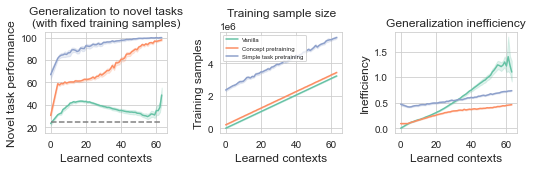

In [182]:
# prac_acc = df.loc[df['Condition']=='Practiced']
# rule2_acc = df.loc[df['Condition']=='2-rule overlap']
# rule1_acc = df.loc[df['Condition']=='1-rule overlap']
plt.figure(figsize=(7.5,2.5))
plt.subplot(1,3,1)
ax = sns.lineplot(x="NumPracticedTasks",y="Accuracy",hue="Training",data=df_all,palette="Set2",legend=False)
plt.plot(np.arange(0,64),np.repeat(25,len(np.arange(0,64))),'gray',linestyle='--')
# plt.plot(np.arange(4,64),np.repeat(.80,len(np.arange(4,64))),'r',linestyle='--',label='Training cut-off on practice')
plt.title('Generalization to novel tasks\n(with fixed training samples)', fontsize=12)
plt.xlabel('Learned contexts', fontsize=12)
plt.ylabel('Novel task performance', fontsize=12)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.ylim([15,105])
# handles, labels = ax.get_legend_handles_labels()
# l = plt.legend(handles[1:4], labels[1:4],fontsize=6)

plt.subplot(1,3,2)
ax = sns.lineplot(x="NumPracticedTasks",y="TotalTrials",hue="Training",data=df_all,palette="Set2")
# plt.plot(np.arange(4,64),np.repeat(.80,len(np.arange(4,64))),'r',linestyle='--',label='Training cut-off on practice')
plt.title('Training sample size', fontsize=12,y=1.1)
plt.xlabel('Learned contexts', fontsize=12)
plt.ylabel('Training samples', fontsize=12)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[1:4], labels[1:4],fontsize=6)

plt.subplot(1,3,3)
ax = sns.lineplot(x="NumPracticedTasks",y="Learning inefficiency",hue="Training",data=df_all,palette="Set2",legend=False)
# plt.plot(np.arange(0,64),np.repeat(25,len(np.arange(0,64))),'gray',linestyle='--')
# plt.plot(np.arange(4,64),np.repeat(.80,len(np.arange(4,64))),'r',linestyle='--',label='Training cut-off on practice')
plt.title('Generalization inefficiency', fontsize=12)
plt.xlabel('Learned contexts', fontsize=12)
plt.ylabel('Inefficiency', fontsize=12)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
# ax.set_yscale("log")
# plt.ylim([15,105])
# handles, labels = ax.get_legend_handles_labels()
# l = plt.legend(handles[1:4], labels[1:4],fontsize=6)

plt.tight_layout()
plt.savefig('Expt8a_FixedEpochs.png',dpi=300)

#### Calculate statistics at 40 practiced tasks trained

In [19]:
tmpdf = df_all.loc[df_all.NumPracticedTasks==40]
performance_diff = tmpdf.Accuracy[tmpdf.Training=='Concept pretraining'].mean()/tmpdf.Accuracy[tmpdf.Training=='Vanilla'].mean()
sample_sizediff = tmpdf.TotalTrials[tmpdf.Training=='Concept pretraining'].mean()/tmpdf.TotalTrials[tmpdf.Training=='Vanilla'].mean()
print('Concept training versus Vanilla')
print('\tPerformance difference:', performance_diff, '| Sample size difference:', sample_sizediff)

performance_diff = tmpdf.Accuracy[tmpdf.Training=='Simple task pretraining'].mean()/tmpdf.Accuracy[tmpdf.Training=='Vanilla'].mean()
sample_sizediff = tmpdf.TotalTrials[tmpdf.Training=='Simple task pretraining'].mean()/tmpdf.TotalTrials[tmpdf.Training=='Vanilla'].mean()
print('2-rule task training versus Vanilla')
print('\tPerformance difference:', performance_diff, '| Sample size difference:', sample_sizediff)

Concept training versus Vanilla
	Performance difference: 2.309304411644786 | Sample size difference: 1.1036335937500001
2-rule task training versus Vanilla
	Performance difference: 2.7932223529548823 | Sample size difference: 2.1930625
